# Training

This treats the spectrograms of the words like images

In [1]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

2023-08-14 17:04:35.674721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 17:04:44.469077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 17:04:44.479501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 17:05:03.049942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# clear out any old logs
!rm -rf ./logs/ 

In [6]:
# List of the words in categorical order
command_words = [
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
]

In [7]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

In [8]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]
print(IMG_WIDTH, IMG_HEIGHT)

99 43


In [11]:
# check dims of some of our data
for i in range(10):
    print(X_train[i].shape[0], X_train[i].shape[1])

99 43
99 43
99 43
99 43
99 43
99 43
99 43
99 43
99 43
99 43


(array([44520., 49000., 37520., 42220., 78183.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

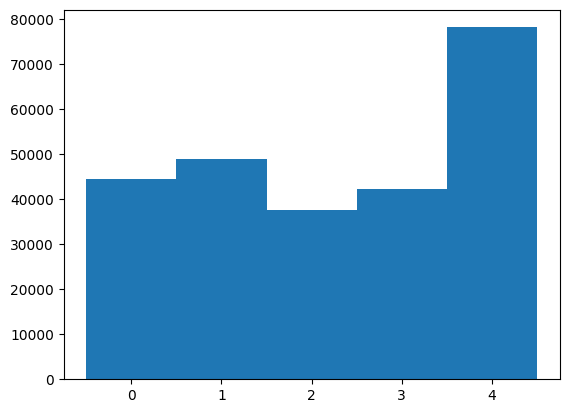

In [9]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(command_words)+1), align='left')

In [10]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3 4] [44520 49000 37520 42220 78183]


{'forward': 44520,
 'backward': 49000,
 'left': 37520,
 'right': 42220,
 '_invalid': 78183}

In [11]:
Y_train = tf.one_hot(Y_train_cats, len(command_words))
Y_validate = tf.one_hot(Y_validate_cats, len(command_words))
Y_test = tf.one_hot(Y_test_cats, len(command_words))

In [ ]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [ ]:
model = Sequential([
    Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='conv_layer1', input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='hidden_layer1'),
    Dropout(0.1),
    Dense(len(command_words), activation='softmax', kernel_regularizer=regularizers.l2(0.001), name='output')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 99, 43, 4)         40        
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)         0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 49, 21, 4)         148       
_________________________________________________________________
max_pooling3 (MaxPooling2D)  (None, 24, 10, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 960)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 80)               

In [ ]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/10
   1/7857 [..............................] - ETA: 4s - loss: 1.8019 - accuracy: 0.1875WARNING:tensorflow:From /home/ubuntu/command-recognition/venv/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7853/7857 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.8466WARNING:tensorflow:From /home/ubuntu/command-recognition/venv/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorfl

In [ ]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


# Testing the Model

In [ ]:
model2 =  keras.models.load_model("trained.model")

In [ ]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

247/247 [==============================] - 1s 6ms/step - loss: 0.3984 - accuracy: 0.9114


In [ ]:
predictions = model2.predict(X_test, 128)

In [ ]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

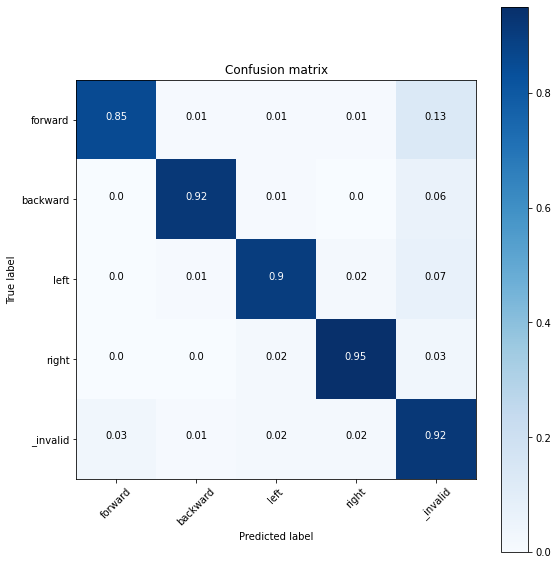

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

# Fully train the model

In [ ]:
batch_size = 30
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(len(complete_train_X)).batch(batch_size)

In [ ]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
10479/10479 [==============================] - 59s 6ms/step - loss: 0.3697 - accuracy: 0.9165
Epoch 2/5
10479/10479 [==============================] - 59s 6ms/step - loss: 0.3703 - accuracy: 0.9169
Epoch 3/5
10479/10479 [==============================] - 58s 6ms/step - loss: 0.3691 - accuracy: 0.9175
Epoch 4/5
10479/10479 [==============================] - 59s 6ms/step - loss: 0.3672 - accuracy: 0.9179
Epoch 5/5
10479/10479 [==============================] - 59s 6ms/step - loss: 0.3670 - accuracy: 0.9175


In [ ]:
model2.save("fully_trained.model")

INFO:tensorflow:Assets written to: fully_trained.model/assets


In [ ]:
results = model2.evaluate(complete_train_X, tf.cast(complete_train_Y, tf.float32), batch_size=128)

2457/2457 [==============================] - 14s 6ms/step - loss: 0.3056 - accuracy: 0.9413


In [ ]:
predictions = model2.predict(complete_train_X, 128)

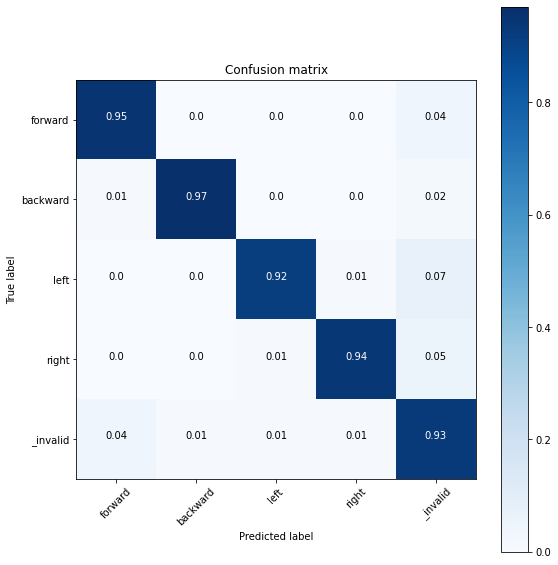

In [ ]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(complete_train_Y, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)